<a href="https://colab.research.google.com/github/nemo0001/Python/blob/master/cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#getting the data from PC

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving cardio_train.csv to cardio_train.csv
User uploaded file "cardio_train.csv" with length 2941524 bytes


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop,Nadam,Adadelta,Adam
from tensorflow.keras.layers import BatchNormalization,LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import seaborn as sns
import scipy.stats as stats
import sklearn
import os


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data_raw=pd.read_csv("cardio_train.csv",sep=";")
data_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
data_raw.drop("id",axis=1,inplace=True)

In [7]:
#handling duplicate values
print("There is {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There is 24 duplicated values in data frame


In [8]:
#We can drop the duplicates because they have no any effect of training of model.
#Firstly let us see the duplicated rows with eyes.
duplicated = data_raw[data_raw.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['age', "gender", "height"], ascending= False) 
# I sorted the values to see duplication clearly

duplicated.head(2) # Show us just 1 duplication of 24

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
2677,22077,1,175,69.0,120,80,1,1,0,0,1,1
45748,22077,1,175,69.0,120,80,1,1,0,0,1,1


In [9]:
data_raw.drop_duplicates(inplace=True)
print("There is {} duplicated values in data frame".format(data_raw.duplicated().sum()))

There is 0 duplicated values in data frame


In [10]:
print("There is {} missing values in data frame".format(data_raw.isnull().sum().sum()))

There is 0 missing values in data frame


In [11]:
#VISUALIZATION
#Detecting Outliers 
#Detecting outlier and handling them can increase our accuracy score.
x = data_raw.copy(deep=True)
x.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,2467.374620,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
#Columns of "age", "height", "weight", "ap_hi", "ap_lo" may have outlier.
#In order to compare them on same scale we need to standardize firstly.
#My Standart Scalar Function
s_list = ["age", "height", "weight", "ap_hi", "ap_lo"]
def standartization(x):
    x_std = x.copy(deep=True)
    for column in s_list:
        x_std[column] = (x_std[column]-x_std[column].mean())/x_std[column].std()
    return x_std 
x_std=standartization(x)
x_std.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,-0.436071,2,0.443399,-0.847978,-0.122181,-0.088254,1,1,0,0,1,0
1,0.307635,1,-1.018016,0.749554,0.072577,-0.035205,3,1,0,0,1,1
2,-0.248017,1,0.078045,-0.709062,0.007658,-0.141303,3,1,0,0,0,1
3,-0.748143,2,0.565184,0.541180,0.137496,0.017844,1,1,0,0,1,1
4,-0.808532,1,-1.018016,-1.264725,-0.187100,-0.194352,1,1,0,0,0,0


In [14]:
#Visualization
#In order to use the multi box graph plot we need to melt out data.
x_melted = pd.melt(frame=x_std, id_vars="cardio", value_vars=s_list, var_name="features", value_name="value", col_level=None)
x_melted

,cardio,features,value
0,0,age,-0.436071
1,1,age,0.307635
2,1,age,-0.248017
3,1,age,-0.748143
4,0,age,-0.808532
...,...,...,...
349875,0,ap_lo,-0.088254
349876,1,ap_lo,-0.035205
349877,1,ap_lo,-0.035205
349878,1,ap_lo,-0.088254


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

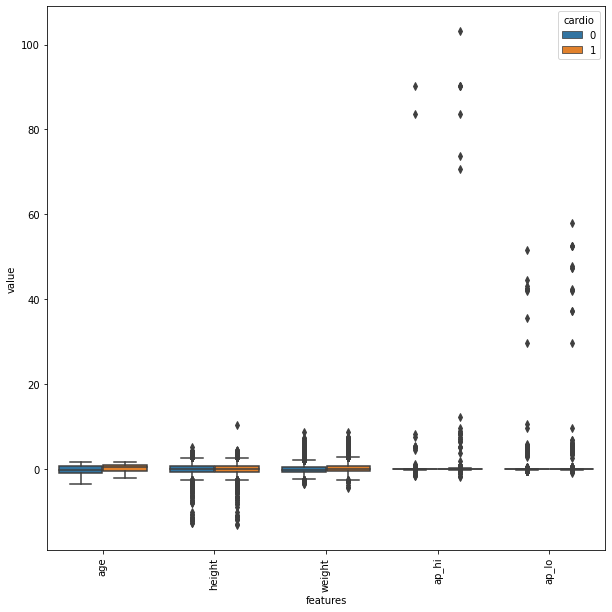

In [15]:
plt.figure(figsize=(10,10))
sns.boxplot(x="features", y="value", hue="cardio", data=x_melted)
plt.xticks(rotation=90)